# Analyse des occupations   

In [1]:
### Librairies externes à ajouter le cas échéant à l'environnement Python actif

from SPARQLWrapper import SPARQLWrapper, JSON, TURTLE, XML, RDFXML

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import networkx as nx

### Librairies déjà installées avec Python

import pprint
import csv
import sys

from importlib import reload



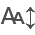

In [2]:
### Module de visualisation de données
#  https://mwouts.github.io/itables/quick_start.html

from itables import init_notebook_mode, show

init_notebook_mode(all_interactive=False)

In [3]:
### Importer un module de fonctions crées ad hoc
##  ATTENTION : le fichier 'sparql_functions.py' doit se trouver 
#   dans un dossier qui se situe dans le chemin ('path') de recherche
#   vu par le présent carnet Jupyter afin que
#   l'importation fonctionne correctement

# Add parent directory to the path
sys.path.insert(0, '..')

### If you want to add the parent-parent directory,
sys.path.insert(0, '../..')


import sparql_functions as spqf

## Importer les donnée à analyser

In [4]:
## define SPARQL enpoint
endpoint = "https://ag16gm9pr0meths2.allegrograph.cloud/repositories/astronomers"

In [9]:
### Get and count persons fields

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?field ?fieldLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {?item wdt:P101 ?field.
        ?field rdfs:label ?occupLabel
        BIND(LCASE(?occupLabel) as ?fieldLabel)    
          }
}
GROUP BY ?field ?fieldLabel 
ORDER BY DESC(?n)
#LIMIT 30
"""

In [10]:
### Execute the query using the local custom fonctions
qr = spqf.get_json_sparql_result(endpoint,query)

In [ ]:
### Count and inspect the available fields
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

2755


[['http://www.wikidata.org/entity/Q413', 'physics', '4225'],
 ['http://www.wikidata.org/entity/Q333', 'astronomy', '1694'],
 ['http://www.wikidata.org/entity/Q395', 'mathematics', '846']]

In [12]:
### Transform the results into a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.head()

,uri,label,effectif
0,http://www.wikidata.org/entity/Q413,physics,4225
1,http://www.wikidata.org/entity/Q333,astronomy,1694
2,http://www.wikidata.org/entity/Q395,mathematics,846
3,http://www.wikidata.org/entity/Q18362,theoretical physics,719
4,http://www.wikidata.org/entity/Q37547,astrophysics,650


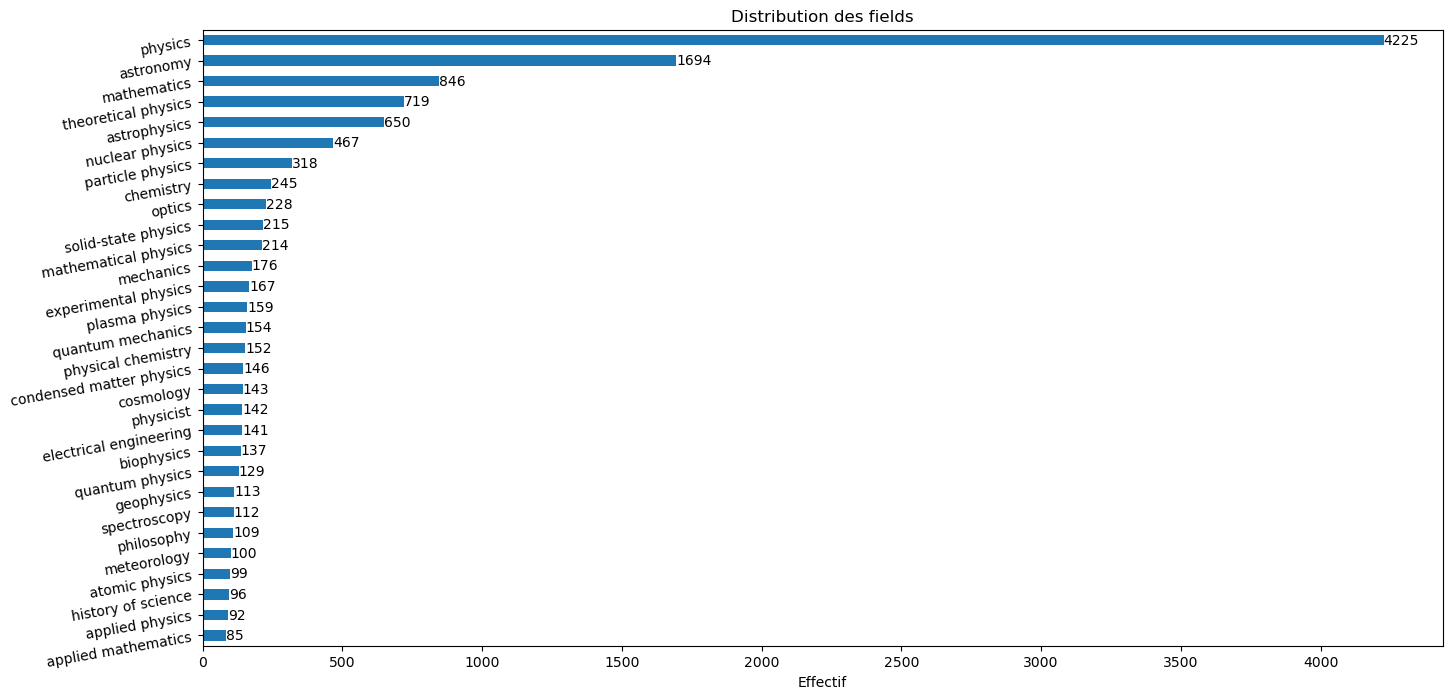

In [13]:
### Bar chart showing distribution by 'field': 
# 30 most frequent fields
ax = df_r['effectif'].head(30).sort_values(ascending=True)\
    .plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(df_r.head(30).label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des fields')
plt.show()

In [14]:
l= len(df_r[df_r['effectif'] == 1])
print(l)

1483


In [15]:
l= len(df_r[df_r['effectif'] < 10])
print(l)

2470


**Comment**: An extreme difference in distribution can be observed: four occupational categories are ten to thirty times larger than the others.

There are 443 occupations with only one person and 800 with less than 10 persons, for a total of 966 different occupations.

### Graphically represent the frequency distribution

There is a wide dispersion of values and a predominant position for activities involving 10 or fewer people

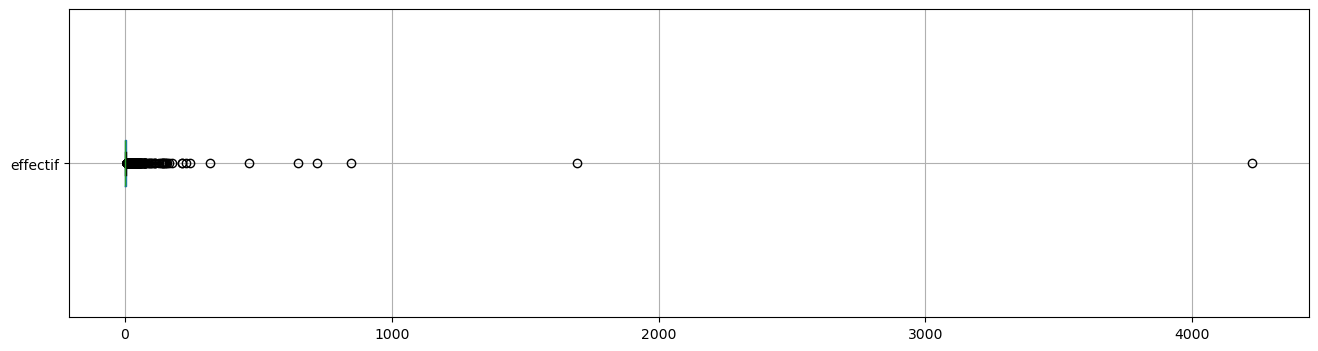

In [16]:
### Distribution des effectifs par field
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

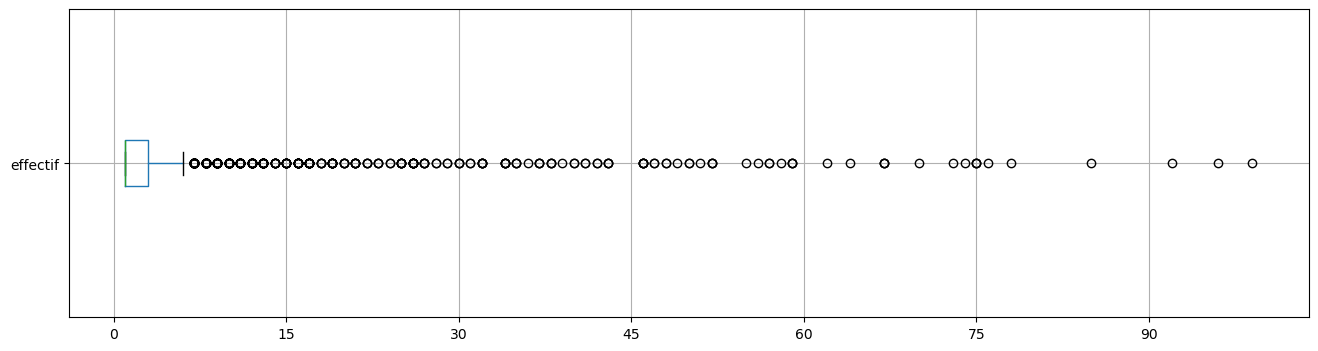

In [18]:
### Distribution des effectifs par occupation
ax = df_r[df_r.effectif<100].boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

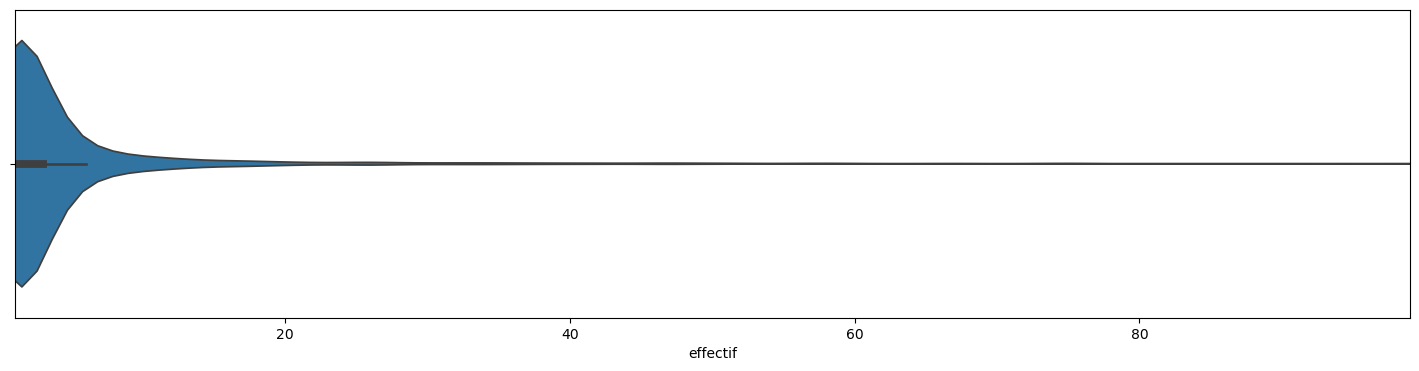

In [17]:
### Represent the density (the total surface has frequency = 1)
# https://seaborn.pydata.org/generated/seaborn.violinplot.html

plt.figure(figsize=(18,4))
d = df_r[df_r.effectif<100].effectif

ax = sns.violinplot(x = d)


### Noter que au delà des limites les valeurs sont coupées car postulées
ax.set_xlim(left=min(d), right=max(d))
plt.show()

### Group by frequency range

In [20]:
### Set the thresholds

ls = [1, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 30000]
print(ls)

[1, 5, 10, 20, 50, 100, 200, 300, 500, 1000, 30000]


In [21]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['seuils'] = pd.cut(df_r['effectif'], ls, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['seuils'] = df_r['seuils'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,uri,label,effectif,seuils
0,http://www.wikidata.org/entity/Q413,physics,4225,1000-29999
1,http://www.wikidata.org/entity/Q333,astronomy,1694,1000-29999
2,http://www.wikidata.org/entity/Q395,mathematics,846,500-999


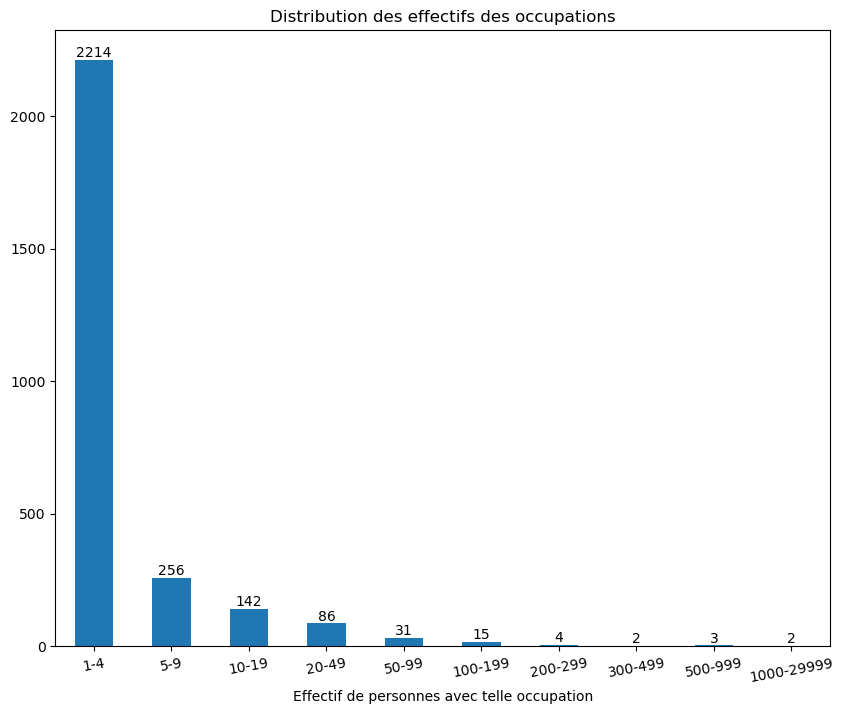

In [22]:
# Plot the grouped distribution

ax = df_r.groupby(by='seuils', observed=False).size()\
    .plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

### Inspect the values

In [23]:
print(df_r[df_r['effectif'] == 1].head(10).label)

1272                  autodidacticism
1273                        q18477660
1274               ultrasonic testing
1275    geographic information system
1276                          compass
1277                  radon transform
1278                          ice age
1279                        insurance
1280                        petrology
1281        eastern orthodox theology
Name: label, dtype: object


In [24]:
print(df_r[df_r['effectif'] == 5].head(10).label)

454                tribology
455    electron spectroscopy
456        planetary physics
457          electron optics
458        cognitive science
459        thermal radiation
460                vibration
461             polarization
462        internal medicine
463                 rheology
Name: label, dtype: object


In [26]:
print(df_r[df_r['effectif'] == 10].head(10).label)

260         x-ray crystallography
261               solar astronomy
262           nuclear engineering
263            quantum technology
264               general physics
265           functional analysis
266    adaptive radiation therapy
267                  radiobiology
268             nonlinear physics
269            mathematical model
Name: label, dtype: object


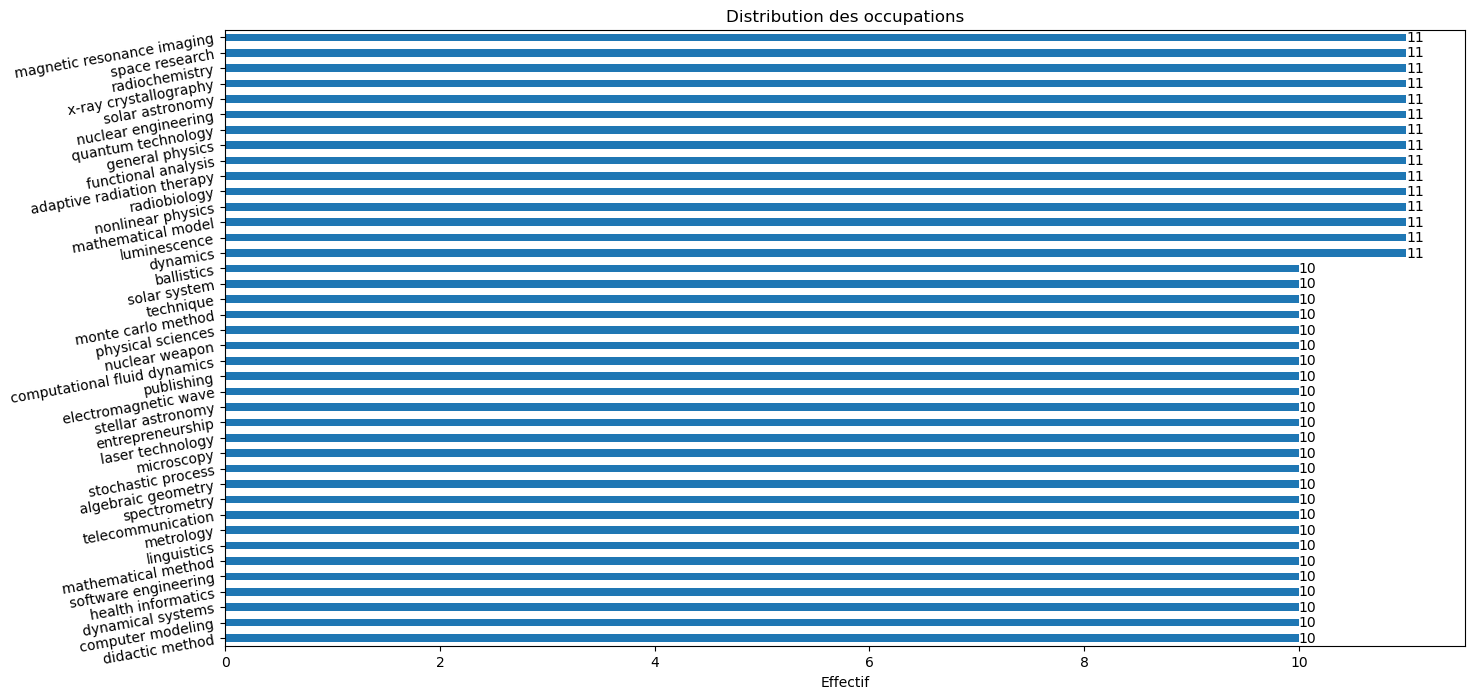

In [27]:
### Bar chart representing the distribution by ‘occupation’ 
# in a given frequency range

d = df_r[(df_r.effectif < 100)&(df_r.effectif > 9)].sort_values(by='effectif',ascending=True).head(40)
ax = d.effectif.plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(d.label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

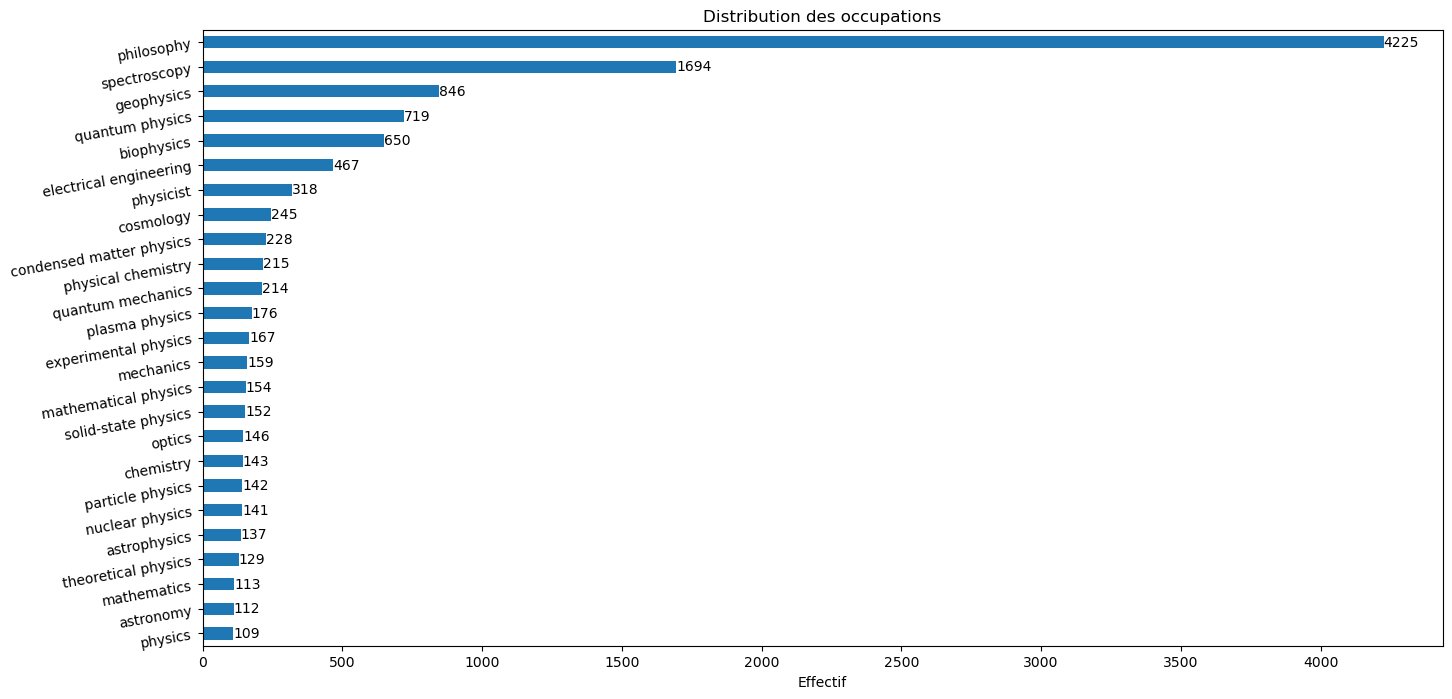

In [28]:
### Bar chart representing the distribution by ‘occupation’ 
# in a given frequency range

d = df_r[df_r.effectif > 100].sort_values(by='effectif',ascending=True)
ax = d.effectif.plot(kind='barh',rot=10, fontsize=10, figsize=(16,8))
y_labels = reversed(d.label.to_list())
ax.set_yticklabels(y_labels)
ax.bar_label(ax.containers[-1])
plt.xlabel('Effectif')
plt.title('Distribution des occupations')
plt.show()

**Comment**

Observation of the typology of occupations reveals a variety that leads to two different types of questions: 
* the specificities of profiles within scientific disciplines
* other activities (artistic, economic, etc.) in their relationship with the disciplines


The aim will be to better define the question or questions we wish to address and to use the information available in Wikidata to create classes.


Another question we could raise is the *changing distribution and configuration over tim*e.

Another question we could ask is the changing distribution and configuration over time. To answer this question, we should add the birth years or generations of the individuals to the characteristics of the occupations.


## Explore the number of fields per person

In [45]:
### Basic query regarding persons' fields

query = """PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?item ?itemLabel (COUNT(*) as ?n)
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {?item wdt:P101 ?field.
        OPTIONAL {?item rdfs:label ?itemLabel}    
          }
}
GROUP BY ?item ?itemLabel
ORDER BY DESC(?n)
#LIMIT 500
"""

In [46]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [47]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

10624


[['http://www.wikidata.org/entity/Q21572913', 'Nikolaus Correll', '19'],
 ['http://www.wikidata.org/entity/Q153224', 'Andrey Kolmogorov', '18'],
 ['http://www.wikidata.org/entity/Q61102142', 'M. F. Tolba', '18']]

In [35]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'effectif']
df_r['effectif'] = df_r.effectif.apply(lambda x : int(x))
df_r.head()

,uri,label,effectif
0,http://www.wikidata.org/entity/Q21572913,Nikolaus Correll,19
1,http://www.wikidata.org/entity/Q61102142,M. F. Tolba,18
2,http://www.wikidata.org/entity/Q153224,Andrey Kolmogorov,18
3,http://www.wikidata.org/entity/Q61816952,T. C. Sum,17
4,http://www.wikidata.org/entity/Q102369764,Didier Felbacq,15


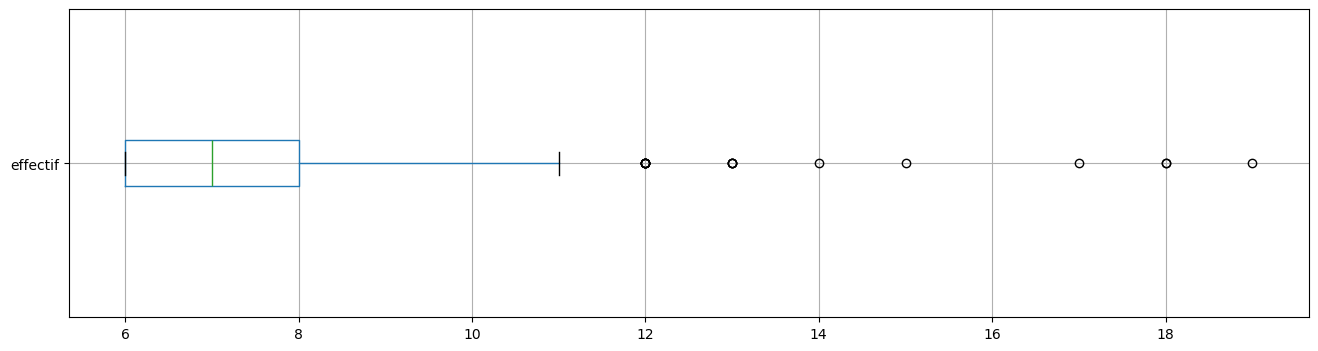

In [37]:
### Distribution of frequencies per person
ax = df_r.boxplot(column=['effectif'], vert=False, figsize=(16,4))

## this fuction avoids ticks with floats instead of integers
#  on the x axis
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

**Comment**

Most persons have between 6 and 8 occupations, with some outliers

86


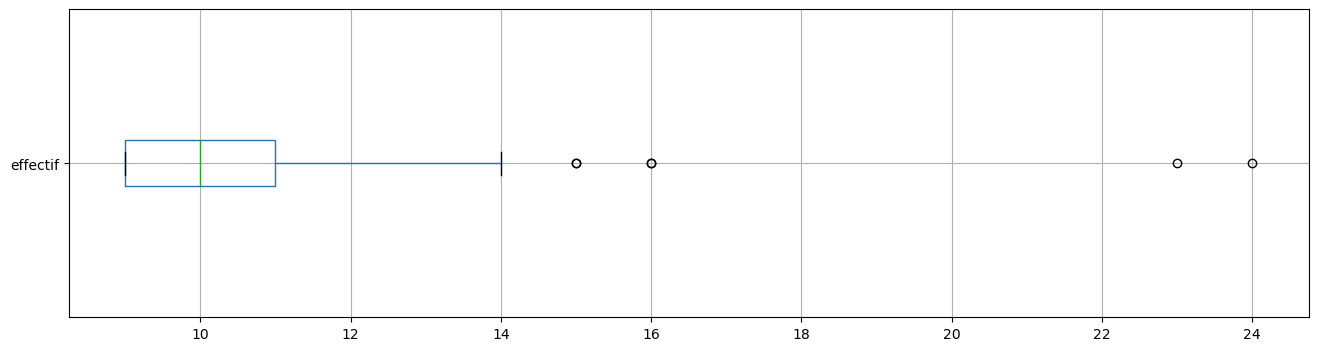

In [28]:
### Distribution des effectifs par occupation

d = df_r[df_r.effectif > 8]
print(len(d))

ax = d.boxplot(column=['effectif'], vert=False, figsize=(16,4))
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

In [29]:
### Cf. the profiles of these persons in Wikidata
pprint.pprint(d.tail())

                                          uri               label  effectif
81     http://www.wikidata.org/entity/Q937063     Tomas M. Milich         9
82     http://www.wikidata.org/entity/Q330225  Eugene Rabinowitch         9
83  http://www.wikidata.org/entity/Q112042673    George Stranahan         9
84     http://www.wikidata.org/entity/Q239131   Evelyn Fox Keller         9
85    http://www.wikidata.org/entity/Q3129074      Heather Couper         9


## Parent occupations

We can try to use the taxonomy of occupations to select relevant occupations.

We therefore go back to the [Import sparqlbook](../../sparqlbooks/wdt_import_occupations.sparqlbook)

In [30]:
query = """
## 

### Simplified query

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>

SELECT DISTINCT 
?occupation ?occupationLabel ?parentField ?parentFieldLabel
?n
          #?parentKnowledgeClassification ?parentKnowledgeClassificationLabel 
          # (SUM(?n) as ?sn)
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {
          SELECT ?occupation ?occupationLabel
          ?parentOccupation (COUNT(*) as ?n)
        
        WHERE
        {
          ?s a wd:Q5;  
              wdt:P106 ?occupation.
          ?occupation rdfs:label ?occupationLabel.
          ?occupation  wdt:P279  ?parentOccupation.
          }  
        GROUP BY ?occupation ?occupationLabel
          ?parentOccupation
        }

        SERVICE <https://query.wikidata.org/sparql>
          {
              # field of parent occupation / instance of /  subclass of  
              ?parentOccupation wdt:P425 / wdt:P31 ?parentField.
              # ?parentField wdt:P279 ?parentKnowledgeClassification.


              #BIND (?occupation as ?occupationLabel)
              BIND (?parentFieldLabel as ?parentFieldLabel)
              # BIND (?parentKnowledgeClassificationLabel as ?parentKnowledgeClassificationLabel)
              SERVICE wikibase:label { bd:serviceParam wikibase:language "en". } 
          }

}
# GROUP BY ?occupation ?occupationLabel ?parentField ?parentFieldLabel
          # ?parentKnowledgeClassification ?parentKnowledgeClassificationLabel 
ORDER BY DESC(?n)
"""

In [31]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [41]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

3084


[['http://www.wikidata.org/entity/Q169470',
  'physicist',
  'http://www.wikidata.org/entity/Q2465832',
  'branch of science',
  '25489'],
 ['http://www.wikidata.org/entity/Q169470',
  'physicist',
  'http://www.wikidata.org/entity/Q11862829',
  'academic discipline',
  '25489'],
 ['http://www.wikidata.org/entity/Q1622272',
  'university teacher',
  'http://www.wikidata.org/entity/Q2465832',
  'branch of science',
  '7750']]

In [47]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uriOccupation', 'labelOccupation', 'uriDomaine', 'labelDomain', 'size']
# df_r['size'] = df_r.size.apply(lambda x : int(x))
df_r.head()

,uriOccupation,labelOccupation,uriDomaine,labelDomain,size
0,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q2465832,branch of science,25489
1,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q11862829,academic discipline,25489
2,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q2465832,branch of science,7750
3,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q26256810,topic,7750
4,http://www.wikidata.org/entity/Q1622272,university teacher,http://www.wikidata.org/entity/Q130303173,service type,7750


In [53]:

## [gb_oc['size'] > 4 ]

show(df_r,  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", # columnDefs=[{"className": "dt-left", "targets": "_all"}],
     search={"regex": True, "caseInsensitive": True},
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading... (need help?)


In [43]:
query = """
### Occupation classifications

PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?birthYear ?o ?oLabel ?oP ?oPLabel
WHERE {
    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
        {?item a wd:Q5;
            wdt:P569 ?birthYear;
            wdt:P106 ?o.
        ?o a wd:Q12737077;
            wdt:P279 ?o1.
        OPTIONAL {?o rdfs:label ?oLabel}    
        OPTIONAL {?oP rdfs:label ?oPLabel}    
          }
}
ORDER BY ?s
"""

In [44]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

QueryBadFormed: A bad request has been sent to the endpoint: probably the SPARQL query is badly formed. 

Response:
b'QUERY MEMORY LIMIT REACHED: This AllegroGraph process is using or is about to use more memory than\nallowed.\n\nAn allocation request of 3.6 GiB would make private memory usage 7.8 GiB.  This\nis 101.8% of RAM, which exceeds the memoryExhaustionWarningPercentage\nquery option (90.0%).\n\nConsider restructuring your query or increasing the value of the\nmemoryExhaustionWarningPercentage query option. \n\nQuery is:\n\n### Occupation classifications\n\nPREFIX franzOption_defaultDatasetBehavior: <franz:rdf>\nPREFIX wd: <http://www.wikidata.org/entity/>\nPREFIX wdt: <http://www.wikidata.org/prop/direct/>\nPREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>\nPREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>\n\nSELECT ?birthYear ?o ?oLabel ?oP ?oPLabel\nWHERE {\n    GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-importe

In [45]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

TypeError: 'NoneType' object is not subscriptable

In [ ]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['year', 'oc_uri', 'oc_label', 'op_uri', 'op_label']
df_r['year'] = df_r.year.apply(lambda x : int(x))
df_r.head()

,year,oc_uri,oc_label,op_uri,op_label
0,1923,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist
1,1908,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist
2,1882,http://www.wikidata.org/entity/Q3126128,geneticist,http://www.wikidata.org/entity/Q864503,biologist
3,1937,http://www.wikidata.org/entity/Q1650915,researcher,http://www.wikidata.org/entity/Q66666685,academic professional
4,1937,http://www.wikidata.org/entity/Q1650915,researcher,http://www.wikidata.org/entity/Q15980158,non-fiction writer


### Codage par période de cinquante ans

In [ ]:
### Créer une liste d'années pour séparer en périodes de 50 ans
# noter que la dernière année sera exclue, 
# elle donc doit être supérieure à la valeur maximale 
d = list(range(1751, 2001, 25))
print(l_25[:5],l_25[-5:], len(l_25)-1)

[1751, 1776, 1801, 1826, 1851] [1851, 1876, 1901, 1926, 1951] 8


In [ ]:
### fonction pd.cut : https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
# On ajoute une nouvelle colonne qui contient la période sur la base de la liste précédente
# et de la valeur de l'année

df_r['per_25'] = pd.cut(df_r['year'], l_25, right=False)

### Transformer le code ajouté pour qu'il soit plus lisible
# noter qu'on a arrondi les valeurs
df_r['per_25'] = df_r['per_25'].apply(lambda x : str(int(x.left))+'-'+ str(int(x.right)-1))

# Inspection
df_r.head(3)

,year,oc_uri,oc_label,op_uri,op_label,per_25
0,1923,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist,1901-1925
1,1908,http://www.wikidata.org/entity/Q169470,physicist,http://www.wikidata.org/entity/Q124637774,physical scientist,1901-1925
2,1882,http://www.wikidata.org/entity/Q3126128,geneticist,http://www.wikidata.org/entity/Q864503,biologist,1876-1900


In [ ]:
### distribution des naissances par périodes de 25 ans
naissances_per = df_p.groupby(by='per_25').size()
print(naissances_per)

per_25
1751-1775     254
1776-1800     326
1801-1825     532
1826-1850     809
1851-1875    1312
1876-1900    1916
1901-1925    4210
1926-1950    8132
dtype: int64


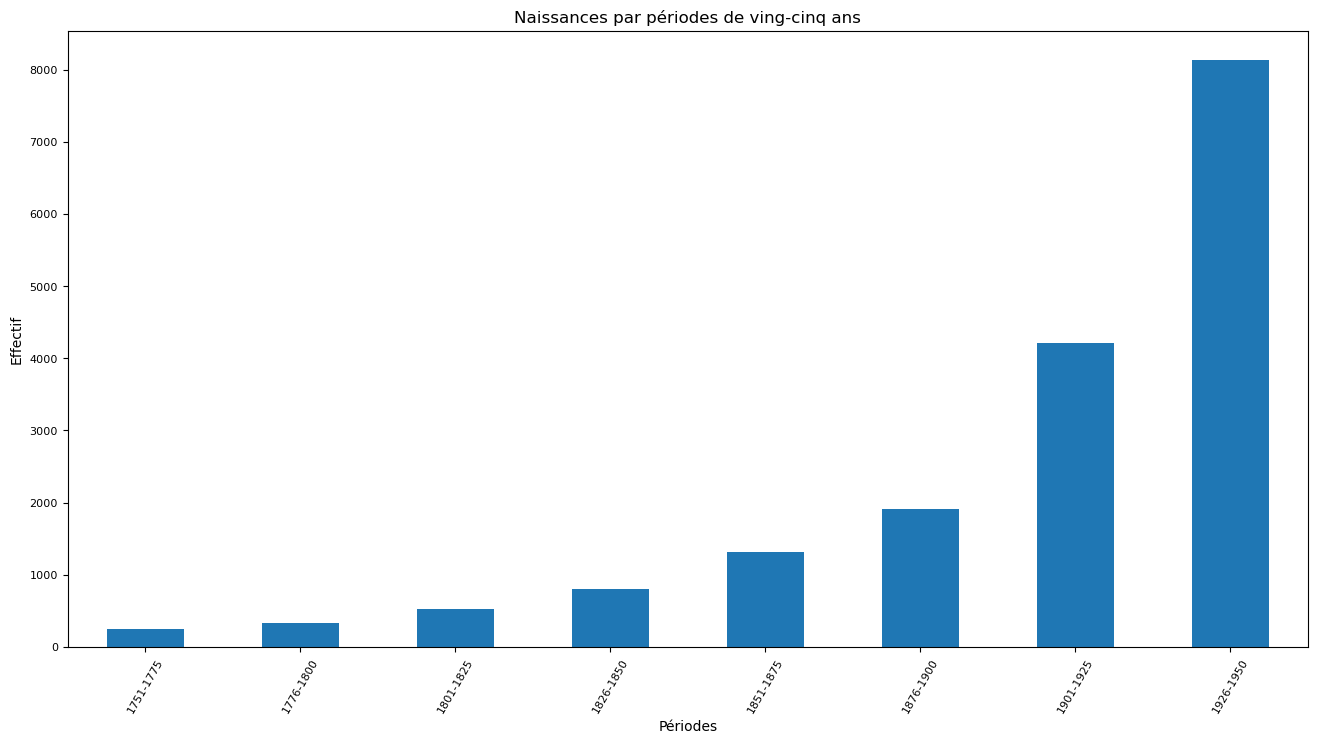

In [ ]:
### Diagramme à barres représentant la distribution par 'génération'
ax = df_p.groupby(by='per_25').size().plot(kind='bar',rot=60, fontsize=8, figsize=(16,8))
plt.ylabel('Effectif')
plt.xlabel('Périodes')
plt.title('Naissances par périodes de ving-cinq ans')
plt.show()

In [ ]:
### distribution des naissances par périodes de 25 ans
gb_oc = df_r.groupby(by=['oc_label','op_label'], observed=False, as_index=False).size()
print(len(gb_oc))
gb_oc.head()

1462


,oc_label,op_label,size
0,Aliyah Bet activist,political activist,2
1,Anglican priest,Anglican clergyman,4
2,Anglican priest,Western priest,4
3,Bible translator,biblical scholar,2
4,Bible translator,translator,2


In [ ]:

## [gb_oc['size'] > 4 ]

show(gb_oc.sort_values(by='size', ascending=False),  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

Loading... (need help?)


## A faire : articuler / séparer la population entre astronomees et physiciens
Chois heuristique de base

# La suite est en préparation

## Paires d'occupations

In [ ]:
query = """
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX wikibase: <http://wikiba.se/ontology#>
PREFIX bd: <http://www.bigdata.com/rdf#>
PREFIX franzOption_defaultDatasetBehavior: <franz:rdf>

## Pour avoir les données avec la personne et l'effectif de toutes les relations
# SELECT DISTINCT ?item ?occupation ?occupationLabel ?occupation_1 ?occupation_1Label

SELECT ?occupation ?occupationLabel ?occupation_1 ?occupation_1Label
WHERE
  {GRAPH <https://github.com/Sciences-historiques-numeriques/astronomers/blob/main/graphs/wikidata-imported-data.md>
     {
      ?item wdt:P106 ?occupation.
      ?item wdt:P106 ?occupation_1.
      ?occupation rdfs:label ?occupationLabel.
      ?occupation_1 rdfs:label ?occupation_1Label.
      FILTER (str(?occupationLabel) < str(?occupation_1Label))
      } 

      }
"""

In [ ]:
### Executer la requête avec les fonctions de la librairie locale
qr = spqf.get_json_sparql_result(endpoint,query)

In [ ]:
r = [l for l in spqf.sparql_result_to_list(qr)]
print(len(r))
r[:3]

In [ ]:
### Transform the results to a dataframe
df_r = pd.DataFrame(r)
df_r.columns=['uri', 'label', 'uri_1', 'label1_']
df_r.uri = df_r.uri.apply(lambda x : x.replace('http://www.wikidata.org/entity/', ''))
df_r.uri_1 = df_r.uri_1.apply(lambda x : x.replace('http://www.wikidata.org/entity/', ''))
df_r.head()

In [ ]:
list(df_r.columns)

In [ ]:
gr = pd.DataFrame(df_r.groupby(['uri', 'label', 'uri_1', 'label1_']).size())
gr.reset_index(inplace=True)
gr.columns=list(df_r.columns)+['size']
gr.sort_values(by='size', ascending=False).head(40)

In [ ]:
gr.sort_values(by='size', ascending=False).tail(40)

In [ ]:
### Distribution des effectifs par occupation
ax = gr.boxplot(column=['size'], vert=False, figsize=(16,4))

In [ ]:
### Distribution des effectifs par occupation
ax = gr[(gr['size']>10) & (gr['size']<500)].boxplot(column=['size'], vert=False, figsize=(16,4))

In [ ]:
ax = gr['size'].plot(kind='bar',rot=10, fontsize=10, figsize=(10,8))
ax.bar_label(ax.containers[-1], fontsize=10)
plt.xlabel('Effectif de personnes avec telle occupation')
plt.title('Distribution des effectifs des occupations')
plt.show()

In [ ]:
plt.figure(figsize=(15, 4))
d = gr[(gr['size'] > 0) & (gr['size'] < 10)]['size']
#d = gr['size']


ax = sns.barplot(x = d)
ax.set_xlim(left=min(d), right=max(d))

ax.plot()

In [ ]:
show(gr[gr['size'] > 4 ].sort_values(by='size', ascending=False),  scrollY="300px",
     scrollCollapse=True, paging=False, layout={"topEnd": None}, 
     showIndex=False, column_filters="header", columnDefs=[{"className": "dt-left", "targets": "_all"}],
     # https://mwouts.github.io/itables/downsampling.html
       maxBytes=0)

## Graphe

In [ ]:


l = []
for i in gr[gr['size'] > 10 ]:
    l.append(tuple((i['uri'],i['uri_1'])))
l[:5]



### A faire

* ajouter ITable pour exploration
* regrouper par type de valeurs
*
* 